In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [98]:
%matplotlib inline

In [99]:
data=pd.read_csv('train.csv')
data.shape

(23116, 25)

In [100]:
test=pd.read_csv('test.csv')
test.shape

(1218, 25)

In [101]:
data.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
0,5498546,0.0,0,40364,0,0.0,3000,560,0.0,0.0,...,0.0,0,0.00,0,0,3,50000,46,NaN,0
1,5498604,1500.0,0,23456,0,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,3,35000,17,NaN,0
2,5498609,0.1,0,17999,3,0.0,9999,9999,0.1,9999.0,...,0.0,0,0.00,0,2,3,35000,58,NaN,0
3,5498645,5000.0,0,313247,0,0.0,0,9999,0.0,0.0,...,0.0,0,4923.97,0,0,5,35000,4,NaN,0
4,5498647,0.0,0,0,1,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,5,35000,34,NaN,0


In [102]:
#создадим списки вещественных и дискретных переменных
real_features=['cred_sum_cc_all',
               'cred_max_overdue_max_ly',
               'cred_sum_cc_ly',
               'cred_sum_debt_all_all',
               'mfo_cred_mean_sum_3lm',
               'cred_max_overdue_max_3lm',
               'cred_sum_overdue_cc_all']

discrete_features=['mfo_inqs_count_month',
                   'all_closed_creds_sum_all',
                   'bank_inqs_count_quarter',
                   'all_active_creds_sum_all',
                   'mfo_last_days_all',
                   'all_closed_creds_sum_ly',
                   'delay_more_sum_all',
                  'all_creds_count_all',
                   'cred_day_overdue_all_sum_all',
                   'mfo_closed_count_ly',
                   'count_overdue_all_3lm',
                   'all_creds_count_lm',
                   'month_income',
                   'region',
                   #'bad',
                   'approved']

cat_features=['work_code']

### Графики распределения Вещественных признаков

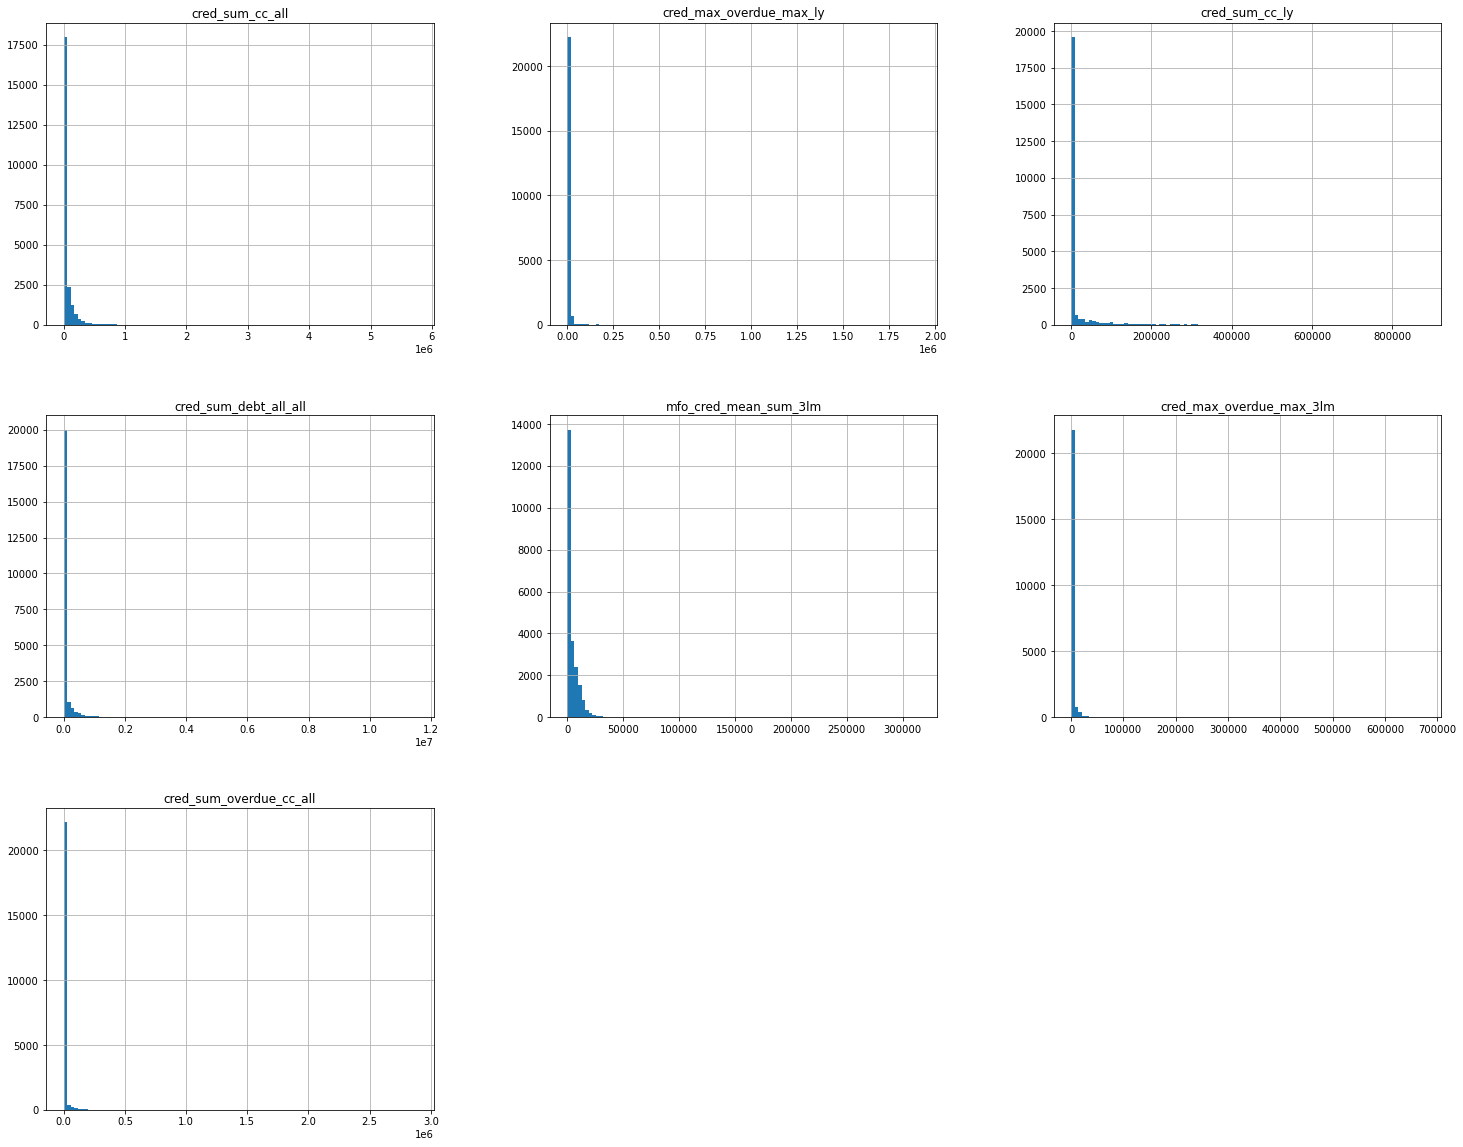

In [103]:
data[real_features].hist(figsize=(25,20),bins=100)
plt.plot()
plt.savefig('graph1.png')

## Графики распределения дискретных признаков

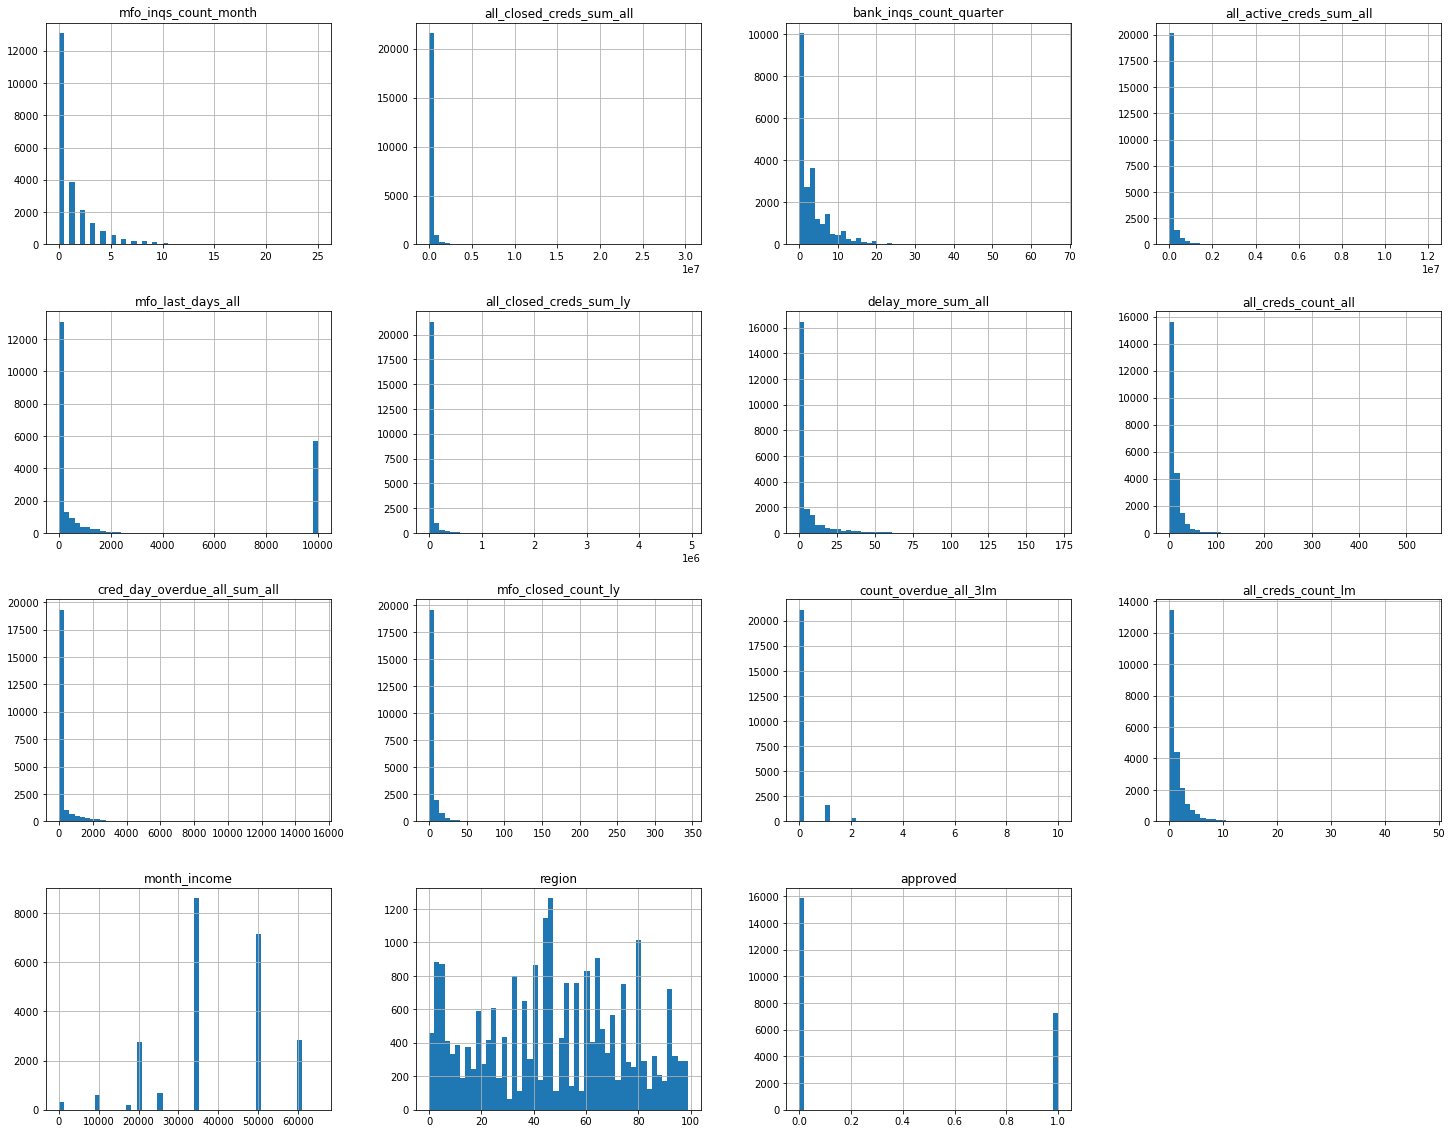

In [104]:
data[discrete_features].hist(figsize=(25,20),bins=50)
plt.plot()
plt.savefig('graph2.png')

In [105]:
data.bad=data.bad.fillna(-1) #заменяе nan значения признака bad для упрощения работы

С помощью бутстрэпа найдем сначала доверительные интервалы для медианных значений признаков каждой из выборок, а затем доверительные интервалы для для разности медиан двух выборок.

In [106]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)) )
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
def conf_int_95(col,n=100):
    values1 = data[data.bad!=(-1)][col].values
    values2 = data[col].values

    np.random.seed(0)

    values1_median_scores = list(map(np.median, get_bootstrap_samples(values1, n)))
    values2_median_scores = list(map(np.median, get_bootstrap_samples(values2, n)))
    
    min1,max1=stat_intervals(values1_median_scores, 0.05)[0],stat_intervals(values1_median_scores, 0.05)[1]
    
    min2,max2=stat_intervals(values2_median_scores, 0.05)[0],stat_intervals(values2_median_scores, 0.05)[1]
    

    #print("95% доверительный интервал "+str(col)+" для выданных кредитов(bad!=nan):",  stat_intervals(values1_median_scores, 0.05))
    #print("95% доверительный интервал "+str(col)+" для всей выборки:",  stat_intervals(values2_median_scores, 0.05))
    #print()
    
    delta_median_scores = list(map(lambda x: x[1] - x[0], zip(values1_median_scores, values2_median_scores)))
    
    delta_min,delta_max=stat_intervals(delta_median_scores, 0.05)[0],stat_intervals(delta_median_scores, 0.05)[1]
    
    #print("95% доверительный интервал для разности медиан",  stat_intervals(delta_median_scores, 0.05))
    return(min1,max1,min2,max2,delta_min,delta_max)

In [107]:
bad_nan_min=[]
bad_nan_max=[]

all_min=[]
all_max=[]

delta_min=[]
delta_max=[]


for feature in real_features:
    
    min1,max1,min2,max2,delt_min,delt_max=conf_int_95(feature,n=1000)
    
    bad_nan_min.append(min1)
    bad_nan_max.append(max1)
    
    all_min.append(min2)
    all_max.append(max2)
    
    delta_min.append(delt_min)
    delta_max.append(delt_max)
    
for feature in discrete_features:
    min1,max1,min2,max2,delt_min,delt_max=conf_int_95(feature,n=1000)
    
    bad_nan_min.append(min1)
    bad_nan_max.append(max1)
    
    all_min.append(min2)
    all_max.append(max2)
    
    delta_min.append(delt_min)
    delta_max.append(delt_max)
    

In [108]:
#создадим небольшой датафрейм для удобства прдеставления границ доверительных интервалов
feats=real_features+discrete_features
conf_intervals=pd.DataFrame(feats)

conf_intervals['approved_min']=bad_nan_min
conf_intervals['approved_max']=bad_nan_max

conf_intervals['all_min']=all_min
conf_intervals['all_max']=all_max

conf_intervals['delta_min']=delta_min
conf_intervals['delta_max']=delta_max

In [109]:
conf_intervals

,0,approved_min,approved_max,all_min,all_max,delta_min,delta_max
0,cred_sum_cc_all,30000.000000,32772.27900,5000.000,5000.000,-27772.279000,-25000.000000
1,cred_max_overdue_max_ly,0.000000,0.00000,0.000,0.000,0.000000,0.000000
2,cred_sum_cc_ly,0.000000,0.00000,0.000,0.000,0.000000,0.000000
3,cred_sum_debt_all_all,42078.807000,46700.00000,4500.000,5000.000,-41830.920875,-37168.423375
4,mfo_cred_mean_sum_3lm,6333.333333,6631.82807,724.375,1483.000,-5783.660714,-4952.753571
5,cred_max_overdue_max_3lm,0.000000,0.00000,0.000,0.000,0.000000,0.000000
6,cred_sum_overdue_cc_all,0.000000,0.00000,0.000,0.000,0.000000,0.000000
7,mfo_inqs_count_month,1.000000,1.00000,0.000,0.000,-1.000000,-1.000000
8,all_closed_creds_sum_all,87998.425000,97019.00000,29700.000,32000.000,-66297.837500,-57334.000000
9,bank_inqs_count_quarter,5.000000,5.00000,2.000,2.000,-3.000000,-3.000000


In [110]:
conf_intervals.to_csv('tabl_conf.csv',sep=';',encoding='utf-8', index=False)

In [111]:
#выведем признаки, доверительные интервалы которых для медианных значений не пересекаются для двух выборок
diff_feats=[]
for i in range(len(conf_intervals)):
    if (conf_intervals.iloc[i].delta_min>0) or (conf_intervals.iloc[i].delta_max<0):
        diff_feats.append(conf_intervals.iloc[i][0])
        
        print(conf_intervals.iloc[i][0])

cred_sum_cc_all
cred_sum_debt_all_all
mfo_cred_mean_sum_3lm
mfo_inqs_count_month
all_closed_creds_sum_all
bank_inqs_count_quarter
all_active_creds_sum_all
mfo_last_days_all
all_closed_creds_sum_ly
all_creds_count_all
mfo_closed_count_ly
all_creds_count_lm
month_income
approved


In [112]:
import scipy

In [113]:
#также можно проверить с помощью критерия Манна-Уитни
diff_feats2=[]
for feature in real_features:
    
    if scipy.stats.mannwhitneyu(data[data.approved==1][feature], data[feature], alternative='two-sided')[1]<0.05:
        diff_feats2.append(feature)
        print(feature)
        
    
for feature in discrete_features:
    if scipy.stats.mannwhitneyu(data[data.approved==1][feature], data[feature], alternative='two-sided'):
        diff_feats2.append(feature)
        print(feature)

cred_sum_cc_all
cred_max_overdue_max_ly
cred_sum_cc_ly
cred_sum_debt_all_all
mfo_cred_mean_sum_3lm
cred_max_overdue_max_3lm
cred_sum_overdue_cc_all
mfo_inqs_count_month
all_closed_creds_sum_all
bank_inqs_count_quarter
all_active_creds_sum_all
mfo_last_days_all
all_closed_creds_sum_ly
delay_more_sum_all
all_creds_count_all
cred_day_overdue_all_sum_all
mfo_closed_count_ly
count_overdue_all_3lm
all_creds_count_lm
month_income
region
approved


In [114]:
len(diff_feats)

14

In [115]:
for feature in diff_feats2:
    if feature not in diff_feats:
        print(feature)

cred_max_overdue_max_ly
cred_sum_cc_ly
cred_max_overdue_max_3lm
cred_sum_overdue_cc_all
delay_more_sum_all
cred_day_overdue_all_sum_all
count_overdue_all_3lm
region


также принадлежность одному распределения двух выборок была проверена с помощью статистического критерия Манна-Уитни, тест манна уитни подтвердил принадлежность к разным распределениям  всех тех признаков, которые были отнесены к разным распределениям на основании доверительных интервалов, помимо этого критерий манна-уитни показал, что к разным распределениям относятся и другие признаки такие как
cred_max_overdue_max_ly
cred_sum_cc_ly
cred_max_overdue_max_3lm
cred_sum_overdue_cc_all
delay_more_sum_all
cred_day_overdue_all_sum_all
count_overdue_all_3lm
region
но при внимательном изучении можно заметить, что значения этих признаков часто повторяются, что делает недопустимым использование данного критерия для определения принадлежности выборок значений к разным распределениям 


# Признаки отличающиеся на выборке выданных кредитов от всей выборки

#### cred_sum_cc_all- сумма кредитов по кредитным картам
Для случаев одобренных кредитов медианное значение заметно выше, чем по всей выборке. У людей с суммой кредитов выше явно большее количество одобренных кредитов, также можно предположить,что они берут кредиты, которые в состоянии оплатить, оценивая объективно свои финансовые способности

#### cred_sum_debt_all_all- Сумма задолженности по всем кредитам
По логике,если клиенту чаще одобряют кредиты, то выше вероятность появления задолженностей, возможно что им продолжают одобрять кредиты,так как время просрочки у них малое, либо они рано или поздно платят за кредит к тому же с процентами за просрочку, что выгодно для кредитора.


#### mfo_cred_mean_sum_3lm-Средняя сумма МФО кредитов, выданных за последние 3 месяца
В данном случае у одобренных кредитов это принак выше. Можно предположить, что если клиенту было одобрено много кредитов в последнее время, то у него хорошая кредитная история, так как выряд либы ему одобрили эти кредиты, то есть можно положиться на клиента, на которого положились в прошлом ,либо же можно предположить, что есть уверенность по другим признакам, что клиент вернет кредит рано или поздно, и в случае просрочки еще и заплатит процент.


#### mfo_inqs_count_month- количество запросов на кредиты в другие в МФО за месяц
Для одобренных кредитов медианное значение выше, могу предположить ,что данный признак надо рассматривать в купе с признаком возвращенных кредитов за последнее время, тогда человек обратившийся в последний месяц за кредитом и вернувший его выглдяит надежным. 

#### all_closed_creds_sum_all-Сумма закрытых кредитов за все время
Для выборки одобренных кредитов данный признак значительно выше, это легко объяснимо, если кредитор видит, чт клиент возвращает долги, то такой клиент выглядит надежным, и можно не беспокоиться о потере средств.


#### bank_inqs_count_quarter- количество запросов на кредиты в банки
Для одобренных кредитов данное значение выше, можно предположить, что если клиент обращается в банк, то у него  есть шанс на получение кредита, что невозможно без хорошей кредитной истории, а раз у него хорошая история, то такой клиент надежен. То есть если с клиентом работают банки, то следовательно с ним также можно работать.

#### all_active_creds_sum_all-денежная сумма всех активных кредитов
у одобренных кредитов данное значение больше, можно предположить, что данный признак логичнее рассматривать в отношении к зарплате, то есть оценивая финансовые возможности клиента.


#### mfo_last_days_all- Количество дней с последнего займа в МФО
Для одобренных кредитов данное значение ниже. Можно предположить ,что люди чаще обращающиеся за кредитами, лучше знакомы с данной ситуацией и могут оценить свое финансовое положение и грамотно вернуть занятые средства.


#### all_closed_creds_sum_ly-Сумма закрытых кредитов за последний год
также как и в случае с  суммами возвращенными за все время, человек возвращающий ердеиты выглядит надежным для кредитора и выгодно оформить ему кредит

#### mfo_closed_count_ly- Количество закрытых МФО кредитов, взятых за последний год
Для одобренных кредитов данный признак выше, что выглядит логичным. Клиенты закрыващие кредиты выглядят надежными и велика вероятность, что и вновь они вернут кредит



#### all_creds_count_all-Общее количество кредитов
У одобренных кредитов данное значение выше, можно предположить, что данный признак важен вкупе с другими признакми, так как например для клиента с малой зарплатой и с большим количеством кредитов меньше вероятность, что он вернет кредит, также важна сама сумма всех кредитов.

#### month_income-месячный доход
для одобренных кредитов данный признак выше, что абсолютно логично, так как человек имеющий бОльшие финансовые возможности выглдяит более надежным клиентом для кредитора, что дает гарантию на возврат кредита.

#### all_creds_count_lm-Количество кредитов, взятых за последний месяц
Для одобренных кредитов данное значение выше, данный признак логичнее рассматривать вкупе с признакками зарплаты, суммы кредитов.

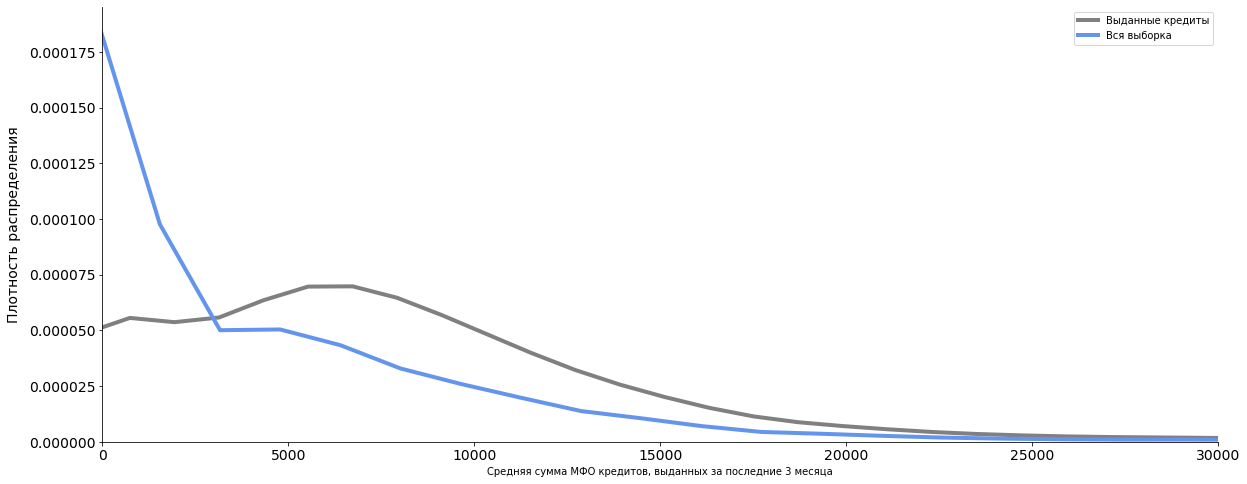

<Figure size 432x288 with 0 Axes>

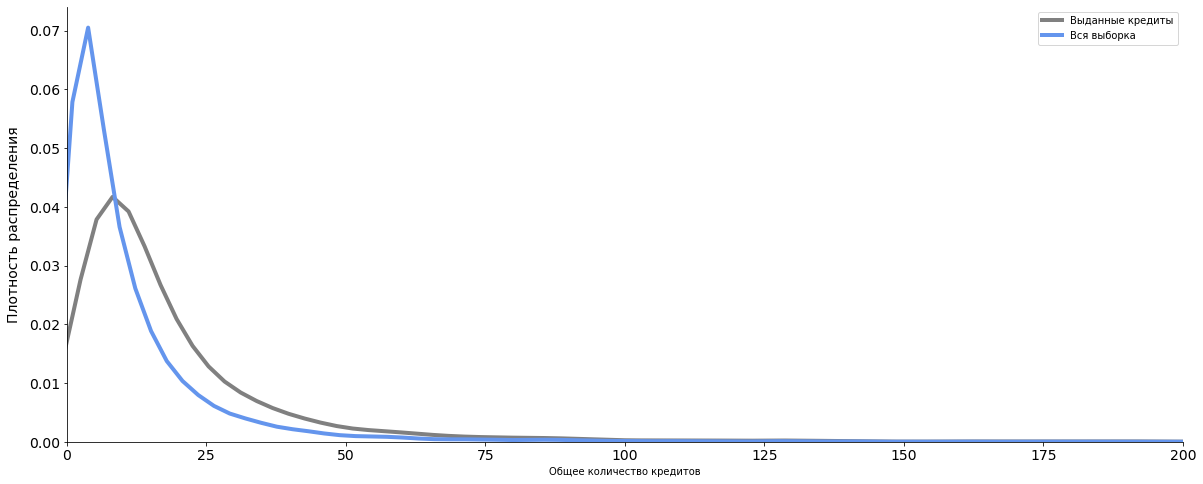

<Figure size 432x288 with 0 Axes>

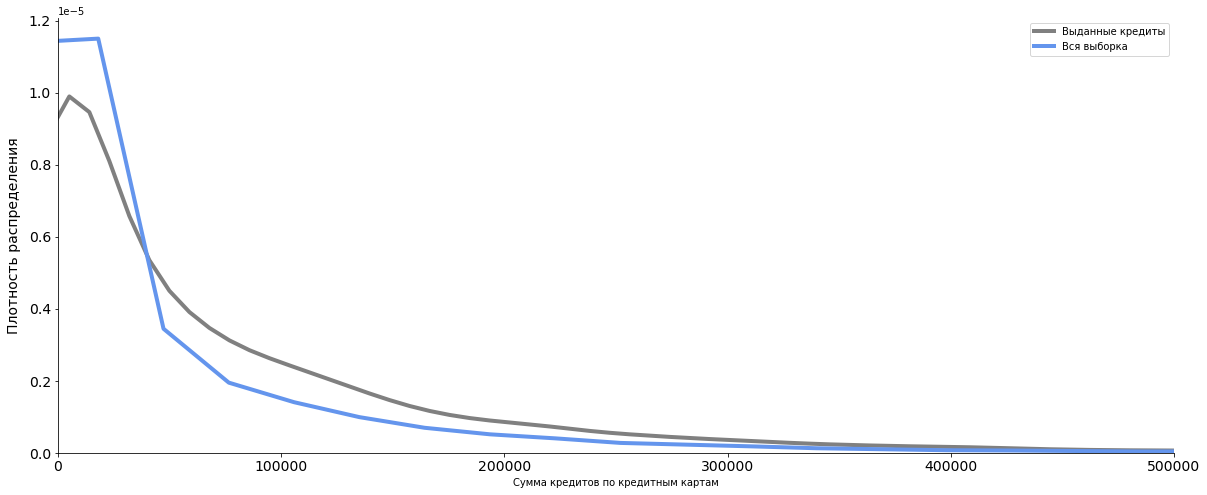

<Figure size 432x288 with 0 Axes>

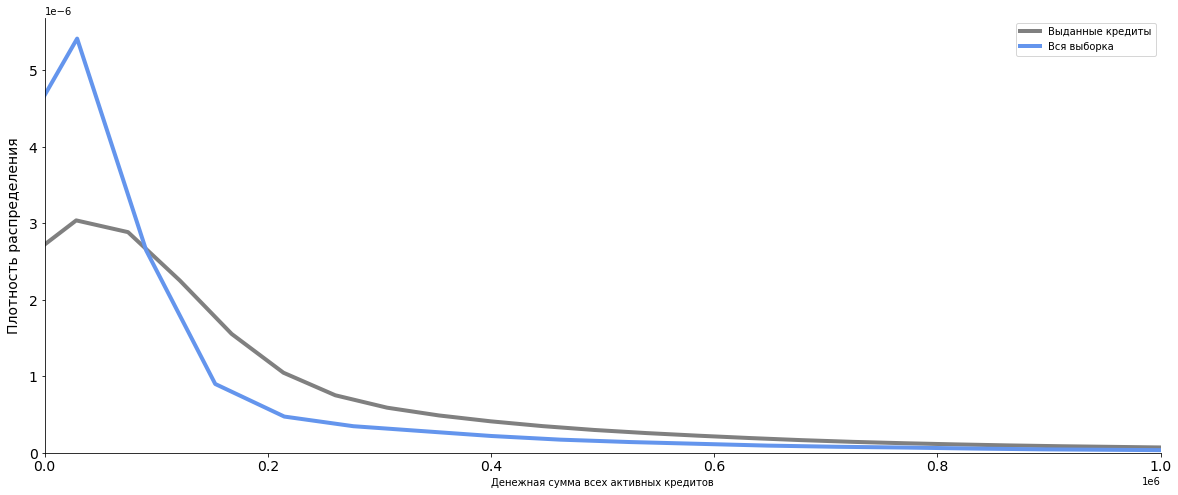

<Figure size 432x288 with 0 Axes>

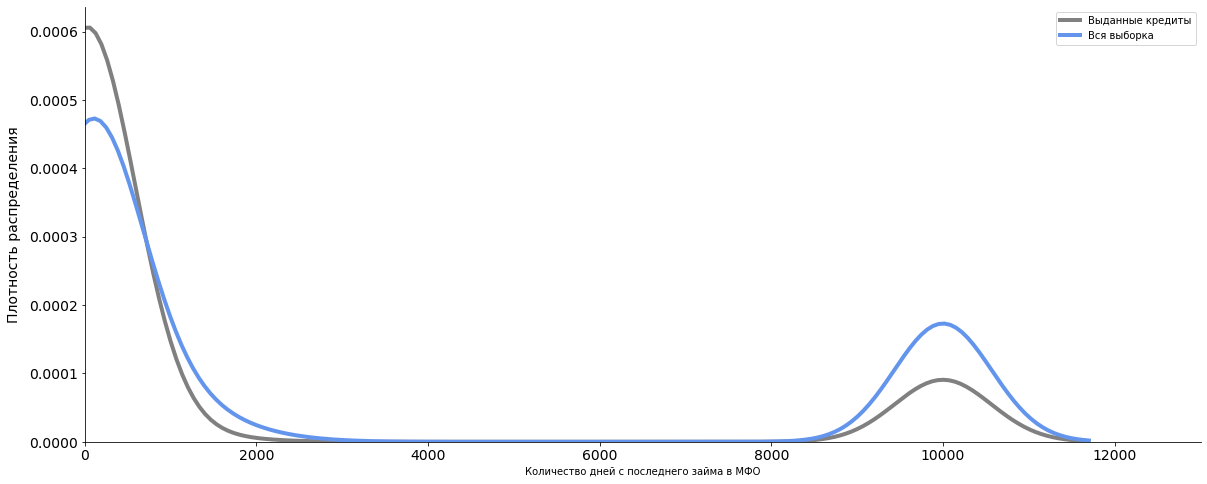

<Figure size 432x288 with 0 Axes>

In [116]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['mfo_cred_mean_sum_3lm'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['mfo_cred_mean_sum_3lm'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Средняя сумма МФО кредитов, выданных за последние 3 месяца')
plt.xlim(0,30000)
plt.legend()
plt.show()
plt.savefig('graph3.png')



plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['all_creds_count_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['all_creds_count_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Общее количество кредитов')
plt.xlim(0,200)
plt.legend()
plt.show()
plt.savefig('graph4.png')



plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['cred_sum_cc_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['cred_sum_cc_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Сумма кредитов по кредитным картам')
plt.xlim(0,500000)
plt.legend()
plt.show()
plt.savefig('graph5.png')



plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['all_active_creds_sum_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['all_active_creds_sum_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Денежная сумма всех активных кредитов')
plt.xlim(0,1000000)
plt.legend()
plt.show()
plt.savefig('graph6.png')




plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['mfo_last_days_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['mfo_last_days_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Количество дней с последнего займа в МФО')
plt.xlim(0,13000)
plt.legend()
plt.show()
plt.savefig('graph7.png')

# Признаки, чьи средние значения совпадают на обеих выборках

#### cred_max_overdue_max_ly-максимальная просрочка за год
Разница между медианными двух выборок не наблюдается.(Судя по значениям в этом признаке находится макс. сумма просроченного кредита, что неочевидно по названию). 
Исходя из этогоможно сказать, что сумма просрочки на год не влияет на одобрение кредита, тем не менее данный признак может быть разным для выборок,если рассматривать его вместе м каким-либо другим признаком вместе(сгенеррировать новые признаки).

#### cred_sum_cc_ly-Сумма лимитов кредитных карт, оформленных за последний год
Медианное значение для двух выборок равно нулю. Лимит кредитных карт может не отражать факт того, что клиент вернет кредит. Кредитная карта может иметь большой лимит, но клиент им никогда и не воспользуется, либо воспользуется, но на сумму гораздо меньшую лимита. Поэтому отсутсвие различий в двух выборках для этого признака вполне логично.

#### cred_max_overdue_max_3lm-Максимальная сумма просроченной задолженности, по кредитам взятым за последние 3 месяца
Медианное значение для двух выборок не отличается. Судя по графику, большие суммы задолженностей-это большая редкость, поэтомудля двух выборок нет различийв медианных значениях, можно предположить, что клиенты очень редко допускают большие просрочки по кредитам.


#### cred_sum_overdue_cc_all-Сумма просрочек по кредитным картам
Также как и для макс. суммы просрочек большинство клиентов не допускают больших просрочек по кредитным картам. Те клиенты, у которых такие все же имеются, можно рассматривать как выбросы. поэтому на медианных значениях это не отражается.



#### all_closed_creds_sum_ly-количество закрытых кредитов за год
Разницы между медианными значениями не наблюдается. Действительно, при выдаче нового кредита куда более важно знать примерно понимание финансового положения клиента, поэтому количество кредитов за последний период более показательно, так как у клиента могут быть разные периоды финансового положения на протяжении всей жизни.


#### cred_day_overdue_all_sum_all- Суммарное количество дней просрочки текущих активных кредитов
Медианные значения не различаются. Так как скорее всего большое колтчество лней просрочки имеется у самого минимального количества клиентов, что также может расцениваться, как выбросы. Возможно, что это просрочка по одному кредиту на малую сумму, но она составляет большое количество дней, это не дает стопроцентной гарантии, что взяв новый кредит он его не вернет.



#### count_overdue_all_3lm- Количество кредитов на просрочке, взятых за последние 3 месяца
Судя по графику, львиная доля клиентов не имеет просрочек вообще за последние три месяца и лишь малая часть имеет их более одного, то есть это можно рассматривать как выбросы.


#### region-регион
Нет различий, следовательно можно сделать вывод, что одбрение кредита не зависит от региона, где живет клиент.

#### delay_more_sum_all-Количество просрочек более чем на 90 дней по всем кредитам
Для всей выборки по оценке медианное значение равно 0, для выборки клиентов, которым одобрили кредит это значение составляет 1. И это не выглядит очевидным, возможно, что этот признак вкупе с какими-то другими признаками дает более логичное объяснение, например с количеством взятых кредитов за последний год или с суммой активных кредитов. Например, если у человека просрочка на 90 дней на малую сумму, при этом клиент всегда возарвщал предыдущие кредиты, и он берет еще один кредит также на малую сумму, то риск может быть на самом деле меньше, чем кажется на первый взгляд на наличие просрочки.

feature_13
feature_4
feature_8
feature_16
feature_9

# Обучение классификатора

In [117]:
# попытка создать новые признаки не увенчалась успехом
def data_feats(data):
    '''
    #data['feature_1']=data['all_closed_creds_sum_all']/data['all_active_creds_sum_all']
    #data['feature_2']=data['cred_sum_cc_all']/data['cred_sum_debt_all_all']
    #data['feature_3']=data['all_active_creds_sum_all']/data['all_creds_count_all']
    #data['feature_4']=data['all_closed_creds_sum_ly']/data['all_creds_count_all']
    data['feature_5']=data['cred_max_overdue_max_ly']/data['month_income']
    data['feature_6']=data['cred_sum_overdue_cc_all']/data['month_income']
    data['feature_7']=data['cred_max_overdue_max_ly']/data['month_income']
    data['feature_8']=data['all_closed_creds_sum_ly']/data['mfo_closed_count_ly']
    data['feature_9']=data['all_creds_count_lm']/data['mfo_inqs_count_month']
    data['feature_10']=data['count_overdue_all_3lm']/3
    data['feature_11']=data['all_creds_count_lm']/30
    data['feature_12']=data['mfo_closed_count_ly']/12
    data['feature_13']=data['mfo_inqs_count_month']/30
    data['feature_14']=data['count_overdue_all_3lm']/data['all_creds_count_lm']
    data['feature_15']=data['cred_max_overdue_max_3lm']/data['cred_max_overdue_max_ly']
    data['feature_16']=data['all_active_creds_sum_all']/data['all_closed_creds_sum_all']
    data['feature_17']=data['cred_max_overdue_max_3lm']/data['month_income']
    data['feature_18']=(data['cred_sum_cc_all']+data['cred_sum_debt_all_all'])/data['month_income']
    data['feature_19']=(data['cred_sum_cc_all']+data['cred_sum_debt_all_all'])
    data['feature_20']=data['all_creds_count_lm']/data['all_closed_creds_sum_all']
    data['feature_21']=data['all_closed_creds_sum_ly']/data['all_closed_creds_sum_all']
    #all_closed_creds_sum_ly
    data['feature_22']=data['all_creds_count_lm']/data['all_creds_count_all']
    '''
    return data

In [118]:
import catboost as ctb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score,train_test_split,TimeSeriesSplit

In [119]:
data=data_feats(data)
data=data.fillna(-999)
data['bad']=data['bad'].astype('int32')



data.replace([np.inf, -np.inf], np.nan,inplace=True)

data_approved=data[data.approved==1]
#data_approved=data_approved.sort_values('order_id')
data_approved=data_approved.drop(['order_id'],axis=1)
data_approved=data_approved.sample(frac=1)

target_approved=data_approved['bad'].astype('int32')


data_approved=data_approved.drop(['bad','approved'],axis=1)

data_approved=data_approved.fillna(-999)

<AxesSubplot:>

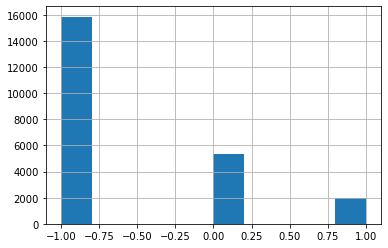

In [120]:
data['bad'].hist()

In [121]:
data.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
0,5498546,0.0,0,40364,0,0.0,3000,560,0.0,0.0,...,0.0,0,0.00,0,0,3,50000,46,-1,0
1,5498604,1500.0,0,23456,0,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,3,35000,17,-1,0
2,5498609,0.1,0,17999,3,0.0,9999,9999,0.1,9999.0,...,0.0,0,0.00,0,2,3,35000,58,-1,0
3,5498645,5000.0,0,313247,0,0.0,0,9999,0.0,0.0,...,0.0,0,4923.97,0,0,5,35000,4,-1,0
4,5498647,0.0,0,0,1,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,5,35000,34,-1,0


In [122]:
data_approved.head()

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,all_creds_count_all,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region
16710,45000.1,1,625104,10,50000.00,45478,10,0.0,40918.90,151500,...,19,0,50000.00,9,0.0,0,2,4,60000,5
17033,244500.0,0,90819,15,3137.71,503700,9999,58000.0,464697.81,0,...,11,0,3137.71,0,0.0,0,0,4,50000,80
7426,10000.0,0,0,1,0.00,87696,9999,10000.0,71631.19,0,...,2,0,0.00,0,0.0,0,0,5,35000,53
14921,0.0,6,53000,3,9000.00,108960,3,0.0,103030.00,53000,...,19,10,9000.00,8,0.0,2,11,5,60000,46
16751,31500.0,1,370049,9,0.00,171500,11,0.0,152729.17,103614,...,44,0,0.00,24,0.0,0,2,2,35000,52


In [123]:
%%time
ctb_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [1000],
    "learning_rate": [0.01],
    'depth':[5],
'class_weights':[(0.7,0.3)]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_cv=GridSearchCV(ctb_clf,param_grid,cv=5,n_jobs=1,verbose=3,scoring='roc_auc')


cat_grid_cv.fit(data_approved,target_approved)
print(cat_grid_cv.best_params_)

best_clf_11=cat_grid_cv.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weights=(0.7, 0.3), depth=5, iterations=1000, learning_rate=0.01;, score=0.606 total time=   3.3s
[CV 2/5] END class_weights=(0.7, 0.3), depth=5, iterations=1000, learning_rate=0.01;, score=0.576 total time=   3.3s
[CV 3/5] END class_weights=(0.7, 0.3), depth=5, iterations=1000, learning_rate=0.01;, score=0.601 total time=   3.2s
[CV 4/5] END class_weights=(0.7, 0.3), depth=5, iterations=1000, learning_rate=0.01;, score=0.628 total time=   3.4s
[CV 5/5] END class_weights=(0.7, 0.3), depth=5, iterations=1000, learning_rate=0.01;, score=0.610 total time=   3.4s
{'class_weights': (0.7, 0.3), 'depth': 5, 'iterations': 1000, 'learning_rate': 0.01}
Wall time: 21 s



{'depth': 5, 'iterations': 1000, 'learning_rate': 0.01}

In [124]:
feature_importances3=best_clf_11.feature_importances_
feature_importances_df3=pd.DataFrame({'features':list(data_approved),
                                     'feature_importances':feature_importances3})
feature_importances_df3=feature_importances_df3.sort_values('feature_importances',ascending=False)
feature_importances_df3

,features,feature_importances
1,mfo_inqs_count_month,9.389451
9,all_closed_creds_sum_ly,8.091318
19,work_code,7.712904
21,region,6.274134
4,cred_max_overdue_max_ly,5.372827
10,mfo_cred_mean_sum_3lm,5.282536
2,all_closed_creds_sum_all,5.035002
15,mfo_closed_count_ly,4.973404
6,mfo_last_days_all,4.348673
8,cred_sum_debt_all_all,4.320590


In [125]:
y_pred=best_clf_11.predict_proba(data_approved)[:,1]

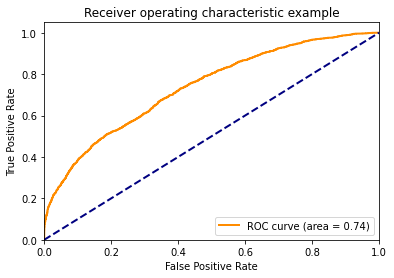

In [126]:

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(target_approved, y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [127]:
# загружаем и обрабатываем тестовые данные
data_test=pd.read_csv('test.csv')
data_test.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
0,5499904,16000.0,0,6890,1,33722.12,33722,9999,0.0,0.00,...,0.00,0,0.00,0,0,5,35000,65,NaN,0
1,5501986,0.0,0,0,5,5000.00,0,289,0.0,0.00,...,0.00,0,0.00,0,0,3,35000,7,NaN,0
2,5503586,133000.0,1,284685,9,16600.00,716305,6,50000.0,593315.33,...,16600.00,4,2409.33,1,4,4,50000,18,1.0,1
3,5507043,10000.0,0,0,0,0.00,0,9999,0.0,0.00,...,0.00,0,9968.84,0,0,5,20000,58,NaN,0
4,5512692,120500.0,0,1293089,8,9605.18,1562678,33,0.0,1392907.34,...,1221.81,1,4442.42,1,0,3,50000,20,0.0,1


In [128]:
data_test=data_feats(data_test)
data_test['bad']=data_test['bad'].fillna(-1)
data_test['bad']=data_test['bad'].astype('int32')

data_test=data_test.fillna(-999)
data_test.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
0,5499904,16000.0,0,6890,1,33722.12,33722,9999,0.0,0.00,...,0.00,0,0.00,0,0,5,35000,65,-1,0
1,5501986,0.0,0,0,5,5000.00,0,289,0.0,0.00,...,0.00,0,0.00,0,0,3,35000,7,-1,0
2,5503586,133000.0,1,284685,9,16600.00,716305,6,50000.0,593315.33,...,16600.00,4,2409.33,1,4,4,50000,18,1,1
3,5507043,10000.0,0,0,0,0.00,0,9999,0.0,0.00,...,0.00,0,9968.84,0,0,5,20000,58,-1,0
4,5512692,120500.0,0,1293089,8,9605.18,1562678,33,0.0,1392907.34,...,1221.81,1,4442.42,1,0,3,50000,20,0,1


In [129]:
data_test_approved=data_test[data_test.approved==1]

target_test_approved=data_test_approved['bad']
data_test_approved=data_test_approved[data_approved.columns]
#data_test_approved=data_test_approved.drop(['bad'],axis=1)


data_test_approved.replace([np.inf, -np.inf], np.nan,inplace=True)
data_test_approved=data_test_approved.fillna(-999)
data_test_approved=data_test_approved[data_approved.columns]

In [130]:
data_test_approved.head()

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,all_creds_count_all,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region
2,133000.00,1,284685,9,16600.00,716305,6,50000.0,593315.33,33400,...,23,9,16600.00,4,2409.33,1,4,4,50000,18
4,120500.00,0,1293089,8,9605.18,1562678,33,0.0,1392907.34,18050,...,22,51,1221.81,1,4442.42,1,0,3,50000,20
5,271084.66,0,52619,4,0.00,0,33,0.0,0.00,41000,...,8,0,0.00,5,27949.66,0,0,5,60000,52
6,0.00,0,53900,2,0.00,0,30,0.0,0.00,50800,...,20,0,0.00,17,0.00,0,1,5,50000,25
7,0.00,1,6000,0,0.00,0,29,0.0,0.00,6000,...,1,0,0.00,1,0.00,0,1,5,35000,57


In [131]:
import sklearn
import sklearn.neighbors
from sklearn.preprocessing import StandardScaler

In [132]:
best_clf_11.fit(data_approved,target_approved)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_11.predict_proba(data_test_approved)[:,1])

0.6318292413182924

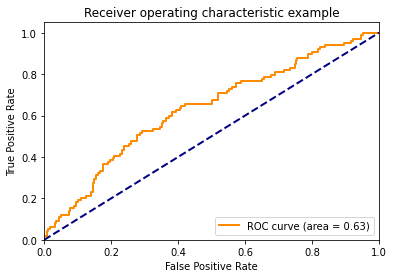

              precision    recall  f1-score   support

           0       0.84      0.24      0.37       274
           1       0.29      0.88      0.44        99

    accuracy                           0.41       373
   macro avg       0.57      0.56      0.41       373
weighted avg       0.70      0.41      0.39       373



In [201]:
y_pred_prob1=best_clf_11.predict_proba(data_test_approved)[:,1]
y_pred1=np.where(y_pred_prob1>0.1,1,0)


from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(target_test_approved, y_pred_prob1)
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print(sklearn.metrics.classification_report(target_test_approved, y_pred1))

стандартные настройки выбивают большмй скор

## Теперь надо разметить невыданные кредиты
Попробуем с помощью KNN

In [38]:
scaler=StandardScaler()
scaler.fit(data_approved)

data_not_approved=data[data.bad==(-1)]
target_not_approved=data_not_approved['bad']

data_not_approved=data_not_approved.fillna(-999)


data_not_approved=data_not_approved[data_approved.columns]


scaled_not_approved=scaler.transform(data_not_approved)
scaled_data_train_approved=scaler.transform(data_approved)

In [39]:
knn=sklearn.neighbors.KNeighborsClassifier()
knn.fit(scaled_data_train_approved,target_approved)

KNeighborsClassifier()

<AxesSubplot:>

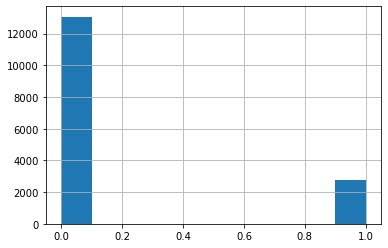

In [40]:
target_not_approved=knn.predict(scaled_not_approved)
pd.Series(list(target_not_approved)).hist(bins=10)

In [41]:
data_not_approved['bad']=target_not_approved
data_approved['bad']=target_approved

In [42]:
data_approved.head()

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad
16710,45000.1,1,625104,10,50000.00,45478,10,0.0,40918.90,151500,...,0,50000.00,9,0.0,0,2,4,60000,5,1
17033,244500.0,0,90819,15,3137.71,503700,9999,58000.0,464697.81,0,...,0,3137.71,0,0.0,0,0,4,50000,80,1
7426,10000.0,0,0,1,0.00,87696,9999,10000.0,71631.19,0,...,0,0.00,0,0.0,0,0,5,35000,53,1
14921,0.0,6,53000,3,9000.00,108960,3,0.0,103030.00,53000,...,10,9000.00,8,0.0,2,11,5,60000,46,0
16751,31500.0,1,370049,9,0.00,171500,11,0.0,152729.17,103614,...,0,0.00,24,0.0,0,2,2,35000,52,0


In [43]:
full_data=pd.concat([data_approved,data_not_approved])
full_data_target=full_data['bad']

full_data=full_data.drop(['bad'],axis=1)
#full_data=full_data.sort_values(by='order_id')

In [44]:
%%time
ctb_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [1000,2000],
    "learning_rate": [0.003],
    'depth':[3,4]}

tscv=TimeSeriesSplit(n_splits=2)
cat_grid_cv=GridSearchCV(ctb_clf,param_grid,cv=tscv,n_jobs=1,verbose=3,scoring='roc_auc')


cat_grid_cv.fit(full_data,full_data_target)
print(cat_grid_cv.best_params_)

best_clf_2=cat_grid_cv.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END depth=3, iterations=1000, learning_rate=0.003;, score=0.694 total time=   3.0s
[CV 2/2] END depth=3, iterations=1000, learning_rate=0.003;, score=0.716 total time=   4.7s
[CV 1/2] END depth=3, iterations=2000, learning_rate=0.003;, score=0.700 total time=   6.2s
[CV 2/2] END depth=3, iterations=2000, learning_rate=0.003;, score=0.735 total time=   8.6s
[CV 1/2] END depth=4, iterations=1000, learning_rate=0.003;, score=0.700 total time=   3.0s
[CV 2/2] END depth=4, iterations=1000, learning_rate=0.003;, score=0.724 total time=   5.6s
[CV 1/2] END depth=4, iterations=2000, learning_rate=0.003;, score=0.707 total time=   6.9s
[CV 2/2] END depth=4, iterations=2000, learning_rate=0.003;, score=0.747 total time=  11.0s
{'depth': 4, 'iterations': 2000, 'learning_rate': 0.003}
Wall time: 1min 1s


In [45]:
best_clf_2.fit(full_data,full_data_target)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_2.predict_proba(data_test_approved)[:,1])

0.6014893460148935

In [46]:
ctb_clf_2=ctb.CatBoostClassifier(verbose=0)
ctb_clf_2.fit(full_data,full_data_target)
sklearn.metrics.roc_auc_score(target_test_approved, ctb_clf_2.predict_proba(data_test_approved)[:,1])

0.6169726461697265

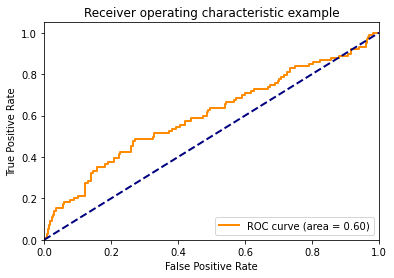

              precision    recall  f1-score   support

           0       0.77      0.04      0.07       274
           1       0.27      0.97      0.42        99

    accuracy                           0.28       373
   macro avg       0.52      0.50      0.24       373
weighted avg       0.64      0.28      0.16       373



In [210]:
y_pred_prob2=best_clf_2.predict_proba(data_test_approved)[:,1]
y_pred2=np.where(y_pred_prob2>0.09,1,0)


from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(target_test_approved, y_pred_prob2)
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print(sklearn.metrics.classification_report(target_test_approved, y_pred2))

## Попробуем разметить через catboost

In [48]:
data_not_approved=data[data.approved==0]
data_not_approved=data_not_approved.fillna(-999)
data_not_approved=data_not_approved[data_approved.columns]
y_predicted_prob=best_clf_1.predict_proba(data_not_approved)[:,1]

<AxesSubplot:>

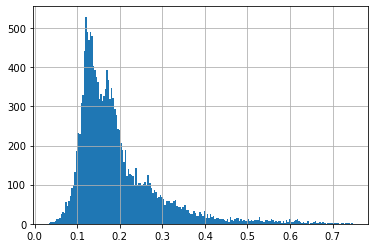

In [49]:
pd.Series(y_predicted_prob).hist(bins=200)

<AxesSubplot:>

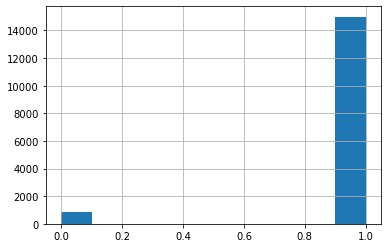

In [50]:
target_not_approved=np.where(y_predicted_prob>0.1,1,0) #threshold для отнесения к классу невозвращенных
#кредитов выбирается медианное значение вероятности возврата


pd.Series(target_not_approved).hist()

In [51]:
data_not_approved['bad']=target_not_approved
data_approved['bad']=target_approved

full_data=pd.concat([data_approved,data_not_approved])

full_target=full_data['bad']
full_data=full_data.drop(['bad'],axis=1)

#full_data=full_data.sort_values(by='order_id')

In [52]:
#full_data=full_data.drop(['order_id'],axis=1)

In [53]:
full_data.head()

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,all_creds_count_all,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region
16710,45000.1,1,625104,10,50000.00,45478,10,0.0,40918.90,151500,...,19,0,50000.00,9,0.0,0,2,4,60000,5
17033,244500.0,0,90819,15,3137.71,503700,9999,58000.0,464697.81,0,...,11,0,3137.71,0,0.0,0,0,4,50000,80
7426,10000.0,0,0,1,0.00,87696,9999,10000.0,71631.19,0,...,2,0,0.00,0,0.0,0,0,5,35000,53
14921,0.0,6,53000,3,9000.00,108960,3,0.0,103030.00,53000,...,19,10,9000.00,8,0.0,2,11,5,60000,46
16751,31500.0,1,370049,9,0.00,171500,11,0.0,152729.17,103614,...,44,0,0.00,24,0.0,0,2,2,35000,52


In [54]:
%%time
ctb_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [2000],
    "learning_rate": [0.004],
    'depth':[4]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_cv=GridSearchCV(ctb_clf,param_grid,cv=5,n_jobs=1,verbose=3,scoring='roc_auc')


cat_grid_cv.fit(full_data,full_target)
print(cat_grid_cv.best_params_)

best_clf_3=cat_grid_cv.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END depth=4, iterations=2000, learning_rate=0.004;, score=0.722 total time=  11.1s
[CV 2/5] END depth=4, iterations=2000, learning_rate=0.004;, score=0.954 total time=  10.9s
[CV 3/5] END depth=4, iterations=2000, learning_rate=0.004;, score=0.957 total time=  11.9s
[CV 4/5] END depth=4, iterations=2000, learning_rate=0.004;, score=0.949 total time=  11.6s
[CV 5/5] END depth=4, iterations=2000, learning_rate=0.004;, score=0.879 total time=  11.3s
{'depth': 4, 'iterations': 2000, 'learning_rate': 0.004}
Wall time: 1min 9s


In [55]:
feature_importances3=best_clf_3.feature_importances_
feature_importances_df3=pd.DataFrame({'features':list(full_data),
                                     'feature_importances':feature_importances3})
feature_importances_df3=feature_importances_df3.sort_values('feature_importances',ascending=False)
feature_importances_df3

,features,feature_importances
13,cred_day_overdue_all_sum_all,27.905026
9,all_closed_creds_sum_ly,12.743461
12,all_creds_count_all,10.797846
2,all_closed_creds_sum_all,8.941134
8,cred_sum_debt_all_all,7.026825
11,delay_more_sum_all,3.886973
19,work_code,3.868932
0,cred_sum_cc_all,3.721108
17,count_overdue_all_3lm,3.427260
3,bank_inqs_count_quarter,3.150765


In [56]:
best_clf_3.fit(full_data,full_target)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_3.predict_proba(data_test_approved)[:,1])

0.5919044459190446

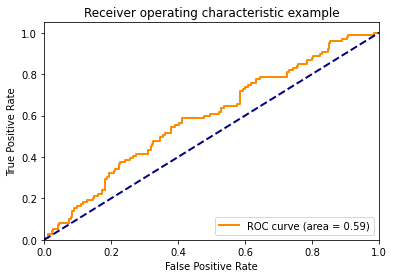

              precision    recall  f1-score   support

           0       0.90      0.10      0.18       274
           1       0.28      0.97      0.44        99

    accuracy                           0.33       373
   macro avg       0.59      0.54      0.31       373
weighted avg       0.74      0.33      0.25       373



In [217]:
y_pred_prob3=best_clf_3.predict_proba(data_test_approved)[:,1]
y_pred3=np.where(y_pred_prob3>0.17,1,0)


from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(target_test_approved, y_pred_prob3)
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print(sklearn.metrics.classification_report(target_test_approved, y_pred3))

### Посмотрим распределения признаков возвратов и невозвратов и на основе этого сделать разметку

In [58]:
def conf_int_95_2(col,n=100):
    values1 = data[data.bad==1][col].values
    values2 = data[data.bad==0][col].values

    np.random.seed(0)

    values1_median_scores = list(map(np.median, get_bootstrap_samples(values1, n)))
    values2_median_scores = list(map(np.median, get_bootstrap_samples(values2, n)))
    
    min1,max1=stat_intervals(values1_median_scores, 0.05)[0],stat_intervals(values1_median_scores, 0.05)[1]
    
    min2,max2=stat_intervals(values2_median_scores, 0.05)[0],stat_intervals(values2_median_scores, 0.05)[1]
    

    #print("95% доверительный интервал "+str(col)+" для выданных кредитов(bad!=nan):",  stat_intervals(values1_median_scores, 0.05))
    #print("95% доверительный интервал "+str(col)+" для всей выборки:",  stat_intervals(values2_median_scores, 0.05))
    #print()
    
    delta_median_scores = list(map(lambda x: x[1] - x[0], zip(values1_median_scores, values2_median_scores)))
    
    delta_min,delta_max=stat_intervals(delta_median_scores, 0.05)[0],stat_intervals(delta_median_scores, 0.05)[1]
    
    #print("95% доверительный интервал для разности медиан",  stat_intervals(delta_median_scores, 0.05))
    return(min1,max1,min2,max2,delta_min,delta_max)

In [59]:
bad_1_min=[]
bad_1_max=[]

bad_0_min=[]
bad_0_max=[]

delta_min=[]
delta_max=[]


for feature in real_features:
    
    min1,max1,min2,max2,delt_min,delt_max=conf_int_95_2(feature,n=1000)
    
    bad_1_min.append(min1)
    bad_1_max.append(max1)
    
    bad_0_min.append(min2)
    bad_0_max.append(max2)
    
    delta_min.append(delt_min)
    delta_max.append(delt_max)
    
for feature in discrete_features:
    min1,max1,min2,max2,delt_min,delt_max=conf_int_95_2(feature,n=1000)
    
    bad_1_min.append(min1)
    bad_1_max.append(max1)
    
    bad_0_min.append(min2)
    bad_0_max.append(max2)
    
    delta_min.append(delt_min)
    delta_max.append(delt_max)
    

In [60]:
#создадим небольшой датафрейм для удобства прдеставления границ доверительных интервалов

conf_intervals2=pd.DataFrame(feats)

conf_intervals2['not_closed_min']=bad_1_min
conf_intervals2['not_closed_max']=bad_1_max

conf_intervals2['closed_min']=bad_0_min
conf_intervals2['closed_max']=bad_0_max

conf_intervals2['delta_min']=delta_min
conf_intervals2['delta_max']=delta_max

In [61]:
conf_intervals2

,0,not_closed_min,not_closed_max,closed_min,closed_max,delta_min,delta_max
0,cred_sum_cc_all,27000.000000,35000.0,29000.098750,33000.000000,-5000.000000,3755.270000
1,cred_max_overdue_max_ly,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,cred_sum_cc_ly,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,cred_sum_debt_all_all,40848.225500,50101.6,41606.474500,46105.683625,-6955.258000,3413.948750
4,mfo_cred_mean_sum_3lm,6254.636364,6875.0,6276.674603,6630.362504,-402.321875,240.598377
5,cred_max_overdue_max_3lm,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,cred_sum_overdue_cc_all,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
7,mfo_inqs_count_month,1.000000,1.0,1.000000,1.000000,0.000000,0.000000
8,all_closed_creds_sum_all,74710.000000,90100.0,91309.400000,101486.500000,5059.912500,23741.100000
9,bank_inqs_count_quarter,5.000000,5.0,5.000000,5.000000,0.000000,0.000000


In [62]:
#выведем признаки, доверительные интервалы которых для медианных значений не пересекаются для двух выборок
diff_feats=[]
for i in range(len(conf_intervals2)):
    if (conf_intervals2.iloc[i].delta_min>0) or (conf_intervals2.iloc[i].delta_max<=0):
        diff_feats.append(conf_intervals2.iloc[i][0])
        print(conf_intervals2.iloc[i][0])
conf_intervals2.rename({0: 'name',}, axis=1, inplace=True)

cred_max_overdue_max_ly
cred_sum_cc_ly
cred_max_overdue_max_3lm
cred_sum_overdue_cc_all
mfo_inqs_count_month
all_closed_creds_sum_all
bank_inqs_count_quarter
all_closed_creds_sum_ly
delay_more_sum_all
cred_day_overdue_all_sum_all
mfo_closed_count_ly
count_overdue_all_3lm
all_creds_count_lm
month_income
approved


In [63]:
conf_intervals2.loc[conf_intervals2['name'].isin(['all_closed_creds_sum_all','all_closed_creds_sum_ly','mfo_closed_count_ly'])]

,name,not_closed_min,not_closed_max,closed_min,closed_max,delta_min,delta_max
8,all_closed_creds_sum_all,74710.00,90100.0,91309.4,101486.5,5059.9125,23741.1
12,all_closed_creds_sum_ly,18398.85,22658.0,25078.9,28500.0,3570.6500,9000.0
16,mfo_closed_count_ly,3.00,3.0,4.0,4.0,1.0000,1.0


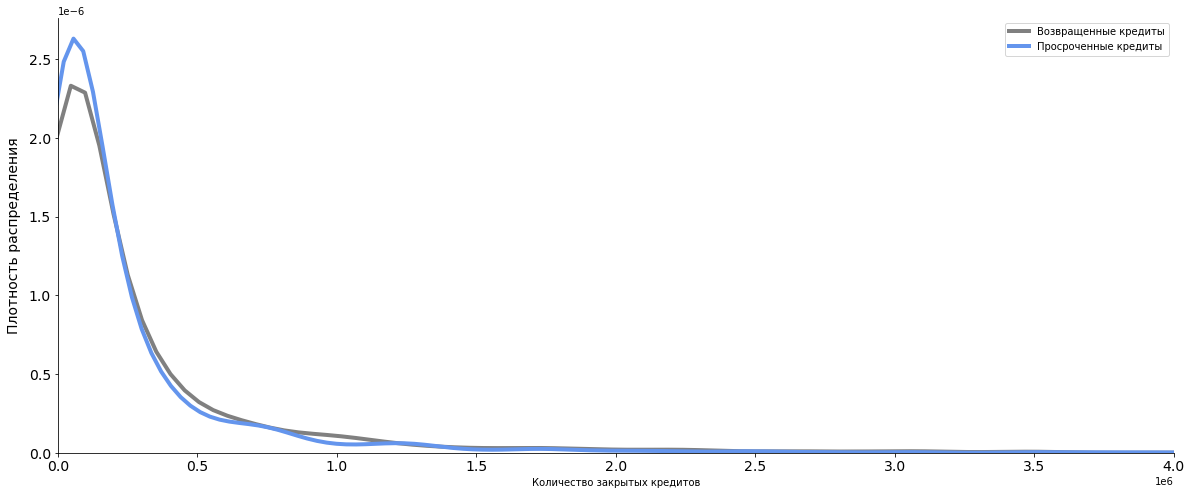

<Figure size 432x288 with 0 Axes>

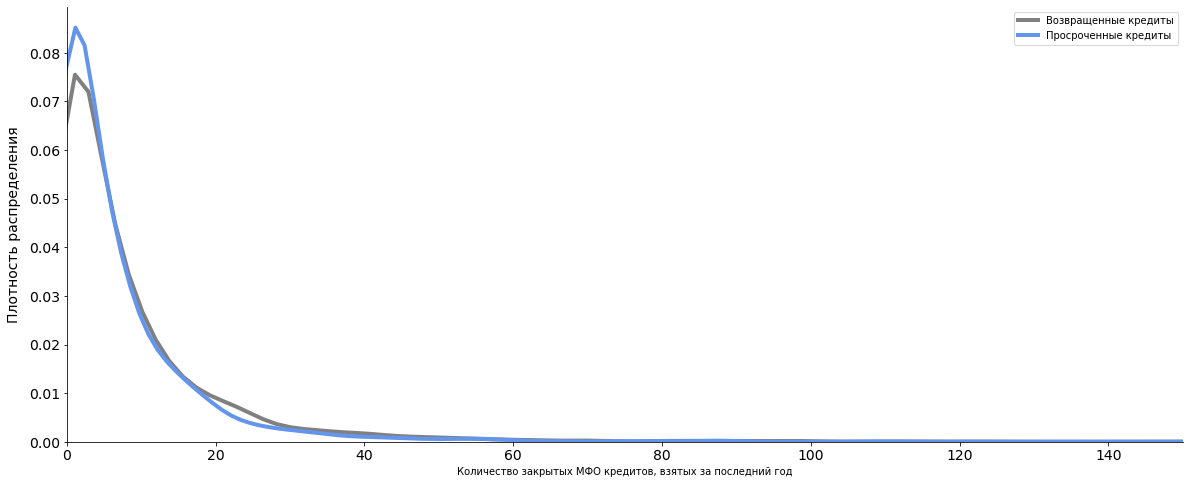

<Figure size 432x288 with 0 Axes>

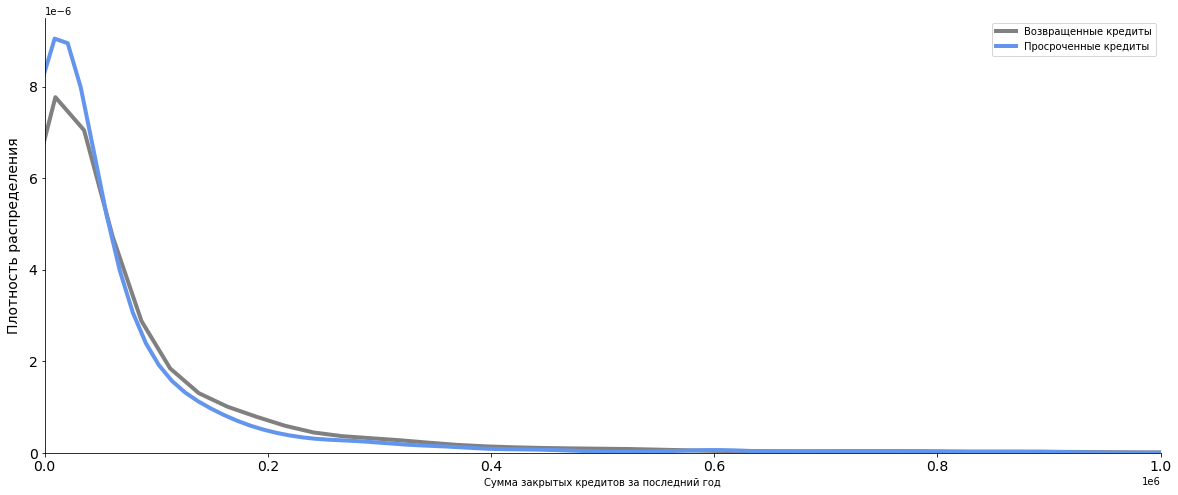

<Figure size 432x288 with 0 Axes>

In [64]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad==0]['all_closed_creds_sum_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Возвращенные кредиты')
sns.distplot(data[data.bad==1]['all_closed_creds_sum_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Просроченные кредиты')
plt.xlabel('Количество закрытых кредитов')
plt.xlim(0,4000000)
plt.legend()
plt.show()
plt.savefig('graph7.png')




plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad==0]['mfo_closed_count_ly'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Возвращенные кредиты')
sns.distplot(data[data.bad==1]['mfo_closed_count_ly'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Просроченные кредиты')
plt.xlabel('Количество закрытых МФО кредитов, взятых за последний год')
plt.xlim(0,150)
plt.legend()
plt.show()
plt.savefig('graph8.png')




plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad==0]['all_closed_creds_sum_ly'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Возвращенные кредиты')
sns.distplot(data[data.bad==1]['all_closed_creds_sum_ly'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Просроченные кредиты')
plt.xlabel('Сумма закрытых кредитов за последний год')
plt.xlim(0,1000000)
plt.legend()
plt.show()
plt.savefig('graph9.png')

In [65]:
%%time
target_not_approved=[]
for i in range(len(data_not_approved)):
    if list(data_not_approved.iloc[i].all_closed_creds_sum_all<=conf_intervals2[conf_intervals2.name=='all_closed_creds_sum_all']['not_closed_max'])[0] and list(data_not_approved.iloc[i].all_closed_creds_sum_ly<=conf_intervals2[conf_intervals2.name=='all_closed_creds_sum_ly']['not_closed_max'])[0] and list(data_not_approved.iloc[i].mfo_closed_count_ly<=conf_intervals2[conf_intervals2.name=='mfo_closed_count_ly']['not_closed_max'])[0]:
        target_not_approved.append(1)
    else:
        target_not_approved.append(0)

Wall time: 25.9 s


In [66]:
data_not_approved['bad']=target_not_approved

data_approved['bad']=target_approved

full_data=pd.concat([data_approved,data_not_approved])

full_target=full_data['bad']
full_data=full_data.drop(['bad'],axis=1)

#full_data=full_data.sort_values(by='order_id')

<AxesSubplot:>

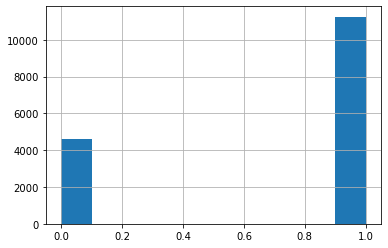

In [67]:
data_not_approved.bad.hist()

In [68]:
%%time
ctb_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [1000,2000],
    "learning_rate": [0.01,0.003],
    'depth':[4,5]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_cv=GridSearchCV(ctb_clf,param_grid,cv=3,n_jobs=1,verbose=3,scoring='roc_auc')


cat_grid_cv.fit(full_data,full_target)
print(cat_grid_cv.best_params_)

best_clf_4=cat_grid_cv.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END depth=4, iterations=1000, learning_rate=0.01;, score=0.783 total time=   4.9s
[CV 2/3] END depth=4, iterations=1000, learning_rate=0.01;, score=0.987 total time=   5.3s
[CV 3/3] END depth=4, iterations=1000, learning_rate=0.01;, score=0.999 total time=   5.6s
[CV 1/3] END depth=4, iterations=1000, learning_rate=0.003;, score=0.779 total time=   5.6s
[CV 2/3] END depth=4, iterations=1000, learning_rate=0.003;, score=0.985 total time=   6.3s
[CV 3/3] END depth=4, iterations=1000, learning_rate=0.003;, score=0.999 total time=   5.4s
[CV 1/3] END depth=4, iterations=2000, learning_rate=0.01;, score=0.783 total time=  12.3s
[CV 2/3] END depth=4, iterations=2000, learning_rate=0.01;, score=0.988 total time=  12.7s
[CV 3/3] END depth=4, iterations=2000, learning_rate=0.01;, score=0.999 total time=  10.9s
[CV 1/3] END depth=4, iterations=2000, learning_rate=0.003;, score=0.782 total time=  11.1s
[CV 2/3] END depth=4, iter

In [69]:
best_clf_4.fit(full_data,full_target)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_4.predict_proba(data_test_approved)[:,1])

0.5724028607240287

In [70]:
best_clf_4=ctb.CatBoostClassifier(verbose=0)
best_clf_4.fit(full_data,full_target)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_4.predict_proba(data_test_approved)[:,1])

0.5817665708176657

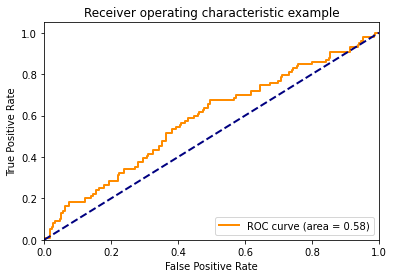

              precision    recall  f1-score   support

           0       0.81      0.49      0.61       274
           1       0.32      0.68      0.44        99

    accuracy                           0.54       373
   macro avg       0.57      0.58      0.52       373
weighted avg       0.68      0.54      0.56       373



In [233]:
y_pred_prob4=best_clf_4.predict_proba(data_test_approved)[:,1]
y_pred4=np.where(y_pred_prob4>0.19,1,0)


fpr, tpr, thresholds = roc_curve(target_test_approved, y_pred_prob4)
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print(sklearn.metrics.classification_report(target_test_approved, y_pred4))

## Через Catboost с частичным привлечением учителя

сделаем следующее: предскажем с помощью первой модели вероятность отнесения к классу 1, и сохраним те объекты, в которых модель уверена больше всего, для этого мы с помощью 5 и 95 процентилей отбираем вероятности из массива вроятностей всех неодобренных кредитов

In [72]:
pd.options.mode.chained_assignment = None  # default='warn'

In [73]:
data_not_approved=data[data.approved==0]
data_not_approved=data_not_approved.fillna(-999)
data_not_approved=data_not_approved[data_approved.columns]

target_approved=data_approved['bad']
data_approved=data_approved.drop(['bad'],axis=1)

data_not_approved=data_not_approved.drop(['bad'],axis=1)

In [74]:
data_approved.head()

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,all_creds_count_all,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region
16710,45000.1,1,625104,10,50000.00,45478,10,0.0,40918.90,151500,...,19,0,50000.00,9,0.0,0,2,4,60000,5
17033,244500.0,0,90819,15,3137.71,503700,9999,58000.0,464697.81,0,...,11,0,3137.71,0,0.0,0,0,4,50000,80
7426,10000.0,0,0,1,0.00,87696,9999,10000.0,71631.19,0,...,2,0,0.00,0,0.0,0,0,5,35000,53
14921,0.0,6,53000,3,9000.00,108960,3,0.0,103030.00,53000,...,19,10,9000.00,8,0.0,2,11,5,60000,46
16751,31500.0,1,370049,9,0.00,171500,11,0.0,152729.17,103614,...,44,0,0.00,24,0.0,0,2,2,35000,52


In [75]:
data_not_approved.head()

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,all_creds_count_all,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region
0,0.0,0,40364,0,0.0,3000,560,0.0,0.0,0,...,3,529,0.0,0,0.00,0,0,3,50000,46
1,1500.0,0,23456,0,0.0,0,9999,0.0,0.0,0,...,3,0,0.0,0,0.00,0,0,3,35000,17
2,0.1,0,17999,3,0.0,9999,9999,0.1,9999.0,0,...,4,0,0.0,0,0.00,0,2,3,35000,58
3,5000.0,0,313247,0,0.0,0,9999,0.0,0.0,0,...,5,0,0.0,0,4923.97,0,0,5,35000,4
4,0.0,0,0,1,0.0,0,9999,0.0,0.0,0,...,1,0,0.0,0,0.00,0,0,5,35000,34


In [76]:
#data_approved=data_approved.drop(['bad'],axis=1)

best_clf_1=ctb.CatBoostClassifier(verbose=0)
best_clf_1.fit(data_approved,target_approved)
#sklearn.metrics.roc_auc_score(target_approved, best_clf_1.predict_proba(data_approved)[:,1])

np.random.seed(0)
score=[]

In [77]:
for i in range(30):
    y_predicted_prob=best_clf_1.predict_proba(data_not_approved)[:,1]

    percent_5=np.percentile(y_predicted_prob, 5)
    percent_95=np.percentile(y_predicted_prob, 95)

    index_percent_5=[]
    index_percent_95=[]

    for i,prob in enumerate(y_predicted_prob):
        if prob<percent_5:
            index_percent_5.append(i)
        if prob>percent_95:
            index_percent_95.append(i)
        
        
    data_not_approved['prob']=y_predicted_prob
    data_not_approved['bad']=np.nan


    data_not_approved_1=data_not_approved[data_not_approved['prob']<percent_5]
    data_not_approved_2=data_not_approved[data_not_approved['prob']>percent_95]

    data_not_approved_1['bad']=0
    data_not_approved_1=data_not_approved_1.drop(['prob'],axis=1)

    data_not_approved_2['bad']=1
    data_not_approved_2=data_not_approved_2.drop(['prob'],axis=1)

    target_not_approved_conf=pd.concat([data_not_approved_1,data_not_approved_2])


    data_approved['bad']=target_approved

    full_data=pd.concat([data_approved,target_not_approved_conf])

    full_target=full_data['bad']
    full_data=full_data.drop(['bad'],axis=1)


    best_clf_1=ctb.CatBoostClassifier(
        #depth=5, iterations= 1000, learning_rate=0.01,
        verbose=0)
    best_clf_1.fit(full_data,full_target)
    
    data_not_approved.drop(list(target_not_approved_conf.index), inplace=True)
    
    print(len(target_not_approved_conf))

    print(sklearn.metrics.roc_auc_score(target_test_approved, best_clf_1.predict_proba(data_test_approved)[:,1]))
    
    score.append(sklearn.metrics.roc_auc_score(target_test_approved, best_clf_1.predict_proba(data_test_approved)[:,1]))

1586
0.6418933864189339
1426
0.6415247364152473
1284
0.6287694462876945
1156
0.6293592862935928
1040
0.6134704711347047
936
0.6202536312025363
842
0.637653911376539
758
0.6337462213374622
682
0.6297279362972794
614
0.6387598613875987
554
0.6351839563518396
498
0.6265944112659441
448
0.6186315711863157
404
0.6293961512939616
362
0.6132124161321242
326
0.651146501511465
294
0.6493032514930325
264
0.6461328614613285
238
0.6484922214849221
214
0.6301703163017032
192
0.6551279215512792
174
0.6412666814126669
156
0.6458010764580107
140
0.6440315564403156
126
0.6478286514782864
114
0.6604364816043649
102
0.6388704563887045
92
0.6424463614244635
84
0.6470913514709136
74
0.6588512865885128


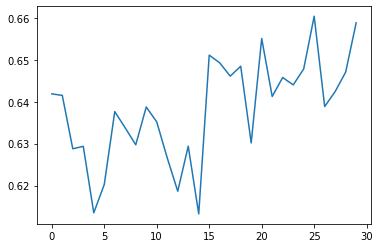

In [78]:
plt.plot(np.arange(0,30),score)

In [79]:
pd.Series(score).describe()

count    30.000000
mean      0.638172
std       0.012414
min       0.613212
25%       0.629479
50%       0.640069
75%       0.646852
max       0.660436
dtype: float64

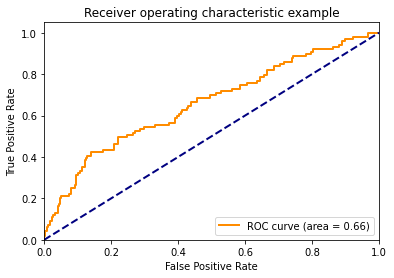

              precision    recall  f1-score   support

           0       0.82      0.49      0.61       274
           1       0.33      0.70      0.45        99

    accuracy                           0.54       373
   macro avg       0.57      0.59      0.53       373
weighted avg       0.69      0.54      0.57       373



In [244]:
y_pred_prob11=best_clf_1.predict_proba(data_test_approved)[:,1]
y_pred11=np.where(y_pred_prob11>0.23,1,0)


fpr, tpr, thresholds = roc_curve(target_test_approved, y_pred_prob11)
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print(sklearn.metrics.classification_report(target_test_approved, y_pred11))